<a href="https://colab.research.google.com/github/yncute/optcg_classifier/blob/main/card_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#NEEDS WORK:
*   (DONE) define functions for image augmentation
*   use dataloaders to create testing/validation sets with augmented data





##Imports

In [ ]:
import json
import pickle
import pandas as pd
import cv2
import imghdr
from PIL import Image, ImageDraw, ImageFilter, ImageEnhance
from urllib.request import urlopen
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import numpy as np
import random
import os
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers
import keras
import matplotlib.pyplot as plt
import shutil
from time import localtime, strftime, time
from natsort import natsorted
from IPython.display import display

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Import dataset locally, sort, and clean of non-jpgs

In [62]:
# Creates a local copy of the dataset and sorts it
def create_local_copy(src, dest):
  if not os.path.exists(dest):
    shutil.copytree(src, dest)
  files = os.listdir(dataset_path)
  files.sort()

# cleans dataset of any non-jpgs and writes a .txt file with removed items
def clean(directory):
  file_paths = []
  non_jpgs = []

  for root, dirs, files in os.walk(directory):
    for file in files:
      path = os.path.join(root, file)
      if imghdr.what(path) != 'jpeg':
        non_jpgs.append(path)
        os.remove(path)
        print(f"Removed non-jpg at path: {path}")


  with open('non-jpgs.txt', 'w') as file:
    for item in non_jpgs:
      file.write(item + '\n')


In [61]:
src = '/content/drive/MyDrive/dataset/optcg_cards'
dataset_path = '/content/dataset_copy'
create_local_copy(src, dataset_path)
clean(dataset_path)

In [63]:
# Load and resize image to 313 x 224 (maintaining apsect ratio of the original 600 x 838)
# def load_image(file_path, image_size=(179, 128)):
#   image = tf.io.read_file(file_path)
#   image = tf.image.decode_jpeg(image, channels=3)
#   image = tf.image.resize(image, image_size)
#   image = image / 255.0 # Normalize to [0,1]
#   return image

In [64]:
def get_file_paths(directory, size=None):
  file_paths = []
  for root, dirs, files in os.walk(directory):
    for file in files:
      if file.endswith(".jpg") and imghdr.what(os.path.join(root, file)) == 'jpeg':
        file_paths.append(os.path.join(root, file))

  file_paths = natsorted(file_paths)
  if size is not None:
    return file_paths
  return file_paths[:size]

# extracts card name from a path
def extract_name(path):
  name = os.path.basename(path).split('.')[0]
  return name

# likely do not need
def convert_labels_to_int(labels):
  unique_labels = sorted(set(labels))
  label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
  int_labels = [label_to_int[label] for label in labels]
  return int_labels, unique_labels



In [65]:
file_paths = get_file_paths(dataset_path)
print(len(file_paths))

labels = convert_labels_to_int(file_paths)
print(labels[0])
print(labels[1])

# function to create datasets
train_dataset = keras.utils.image_dataset_from_directory(
    dataset_path,
    labels=labels[0],
    label_mode="int",
    batch_size=32,
    image_size=(179,128),
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

2429
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 119, 120, 118, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220,

##Image Augmentation Functions

In [57]:
def zoom_rotate_img(image):
    '''Help: Randomly rotate and zoom the given PIL image degrees and return it'''
    #store initial image size
    initial_size = image.size
    #determine at random how much or little we scale the image
    scale = 0.95+random.random()*.1
    scaled_img_size = tuple([int(i*scale) for i in initial_size])


    #create a blank background with a random color and same size as intial image
    bg_color = tuple(np.random.choice(range(256),size=3))
    background = Image.new('RGB', initial_size, bg_color)

    #determine the center location to place our rotated card
    center_box = tuple((n-o)//2 for n,o in zip(initial_size, scaled_img_size))

    #scale the image
    scaled_img = image.resize(scaled_img_size)

    #randomly select an angle to skew the image
    max_angle = 5
    skew_angle = random.randint(-max_angle, max_angle)

    #add the scaled image to our color background
    background.paste(scaled_img.rotate(skew_angle, fillcolor=bg_color,expand=1).resize(scaled_img_size),
                     center_box)

    #potentially flip the image 180 degrees
    if random.choice([True, False]):
        background = background.rotate(180)

    return background

def blur_img(image):
    '''Help: Blur the given PIL image and return it'''
    return image.filter(filter=ImageFilter.BLUR)

def adjust_color(image):
    '''Help: Randomly reduce or increase the saturation of the provided image and return it'''
    converter = ImageEnhance.Color(image)
    #randomly decide to half or double the image saturation
    saturation = random.choice([.5, 1.5])
    return converter.enhance(saturation)

def adjust_contrast(image):
    '''Help: Randomly decrease or increase the contrast of the provided image and return it'''
    converter = ImageEnhance.Contrast(image)
    #randomly decide to half or double the image saturation
    contrast = random.choice([.5, 1.5])
    return converter.enhance(contrast)

def adjust_sharpness(image):
    '''Help: Randomly decrease or increase the sharpness of the provided image and return it'''
    converter = ImageEnhance.Sharpness(image)
    #randomly decide to half or double the image saturation
    sharpness = random.choice([.5, 1.5])
    return converter.enhance(sharpness)

def random_edit_img(image, distort=True, verbose=True):
    '''Help: Make poor edits to the image at random and return the finished copy. Can optionally not distort
    the image if need be.'''

    if distort:
        #randomly choose which editing operations to perform
        edit_permission = np.random.choice(a=[False, True], size=(4))

        #always skew the image, randomly make the other edits
        image = zoom_rotate_img(image)
        if verbose:
            print('Image skewed')
        if edit_permission[0]:
            image = blur_img(image)
            if verbose:
                print('Image blurred')
        if edit_permission[1]:
            image = adjust_color(image)
            if verbose:
                print('Image color adjusted')
        if edit_permission[2]:
            image = adjust_contrast(image)
            if verbose:
                print('Image contrast adjusted')
        if edit_permission[3]:
            image = adjust_sharpness(image)
            if verbose:
                print('Image sharpness adjusted')

    return image

def augment_image(image, distort=True, verbose=True):
    if distort:
      edit_permission = np.random.choice(a=[False, True], size=(5))
      #always skew the image, randomly make the other edits
      image = zoom_rotate_img(image)
      if verbose:
        print('Image skewed')
      if edit_permission[0]:
        image = blur_img(image)
        if verbose:
          print('Image blurred')
      if edit_permission[1]:
        image = adjust_color(image)
        if verbose:
          print('Image color adjusted')
      if edit_permission[2]:
        image = adjust_contrast(image)
        if verbose:
          print('Image contrast adjusted')
      if edit_permission[3]:
        image = adjust_sharpness(image)
        if verbose:
          print('Image sharpness adjusted')

    # # Random rotation
    # image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

    # # Random contrast
    # image = tf.image.random_contrast(image, lower=0.5, upper=1.5)

    # # Random brightness
    # image = tf.image.random_brightness(image, max_delta=0.2)

    # #random saturation
    # image = tf.image.random_saturation(image, lower=0.8, upper=1.2)

    # # Random cropping (reduce size by 10-20%)
    # original_shape = tf.shape(image)
    # crop_fraction = tf.random.uniform([], minval=0.8, maxval=0.9)
    # new_size = tf.cast(tf.cast(original_shape[:2], tf.float32) * crop_fraction, tf.int32)
    # image = tf.image.random_crop(image, size=[new_size[0], new_size[1], original_shape[2]])
    # image = tf.image.resize(image, [original_shape[0], original_shape[1]])

    # # Ensure pixel values are still valid
    # image = tf.clip_by_value(image, 0.0, 1.0)

    return image

# Function to generate augmented images and store them to the specified path
def generate_augmented_images(image_paths, storage_path, sample_size, num_duplicates=5):
  images_created = 0
  printings_distorted = 0
  for path in image_paths[:sample_size]:
    printings_distorted += 1
    print(path)
    raw = Image.open(path)
    # raw = tf.image.decode_jpeg(tf.io.read_file(path)) / 255
    index = image_paths.index(path)
    print(index)

    # Setup folder
    card_name = extract_name(path)
    if not os.path.exists(storage_path):
      os.makedirs(storage_path)

    subdir = f"{storage_path}/{card_name}"
    if not os.path.exists(subdir):
      os.makedirs(subdir)
    raw.save(f"{subdir}/unedited.jpg")

    # Augment images and plot them
    plt.figure(figsize = ((num_duplicates + 1)*4 ,4))
    plt.subplot(1,num_duplicates + 1,1)
    plt.title("original")
    plt.imshow(raw)
    plt.axis('off')
    for i in range(num_duplicates):

      images_created += 1
      augmented = augment_image(raw, verbose=False)

      augmented.save(f"{subdir}/augment-{i}.jpg")

      plt.subplot(1,num_duplicates + 1, i + 2)
      plt.title(f"Augmented {i + 1}")
      plt.imshow(augmented)
      plt.axis('off')

    plt.tight_layout()
    plt.show()

    # folder structure/naming should look like:
    # augmented_data
    # |- <card_name>
    # |--|- unedited.jpg
    # |--|- edits-1,2,etc.jpg
    # |-- <card_name>
    # |--|- unedited.jpg
    # |--|- edits-1,2,etc.jpg

/content/dataset_copy/EN_EB01-001.jpg
0


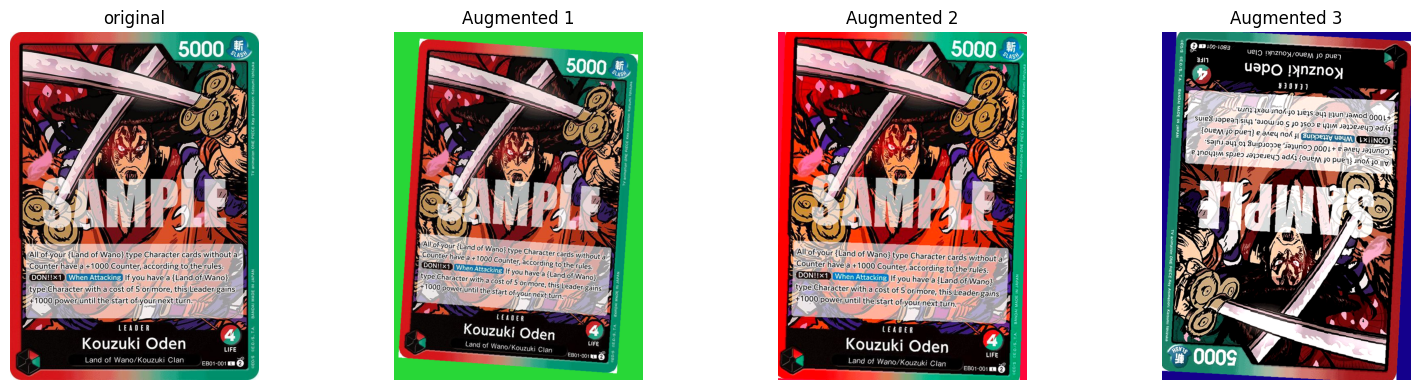

/content/dataset_copy/EN_EB01-001_p1.jpg
1


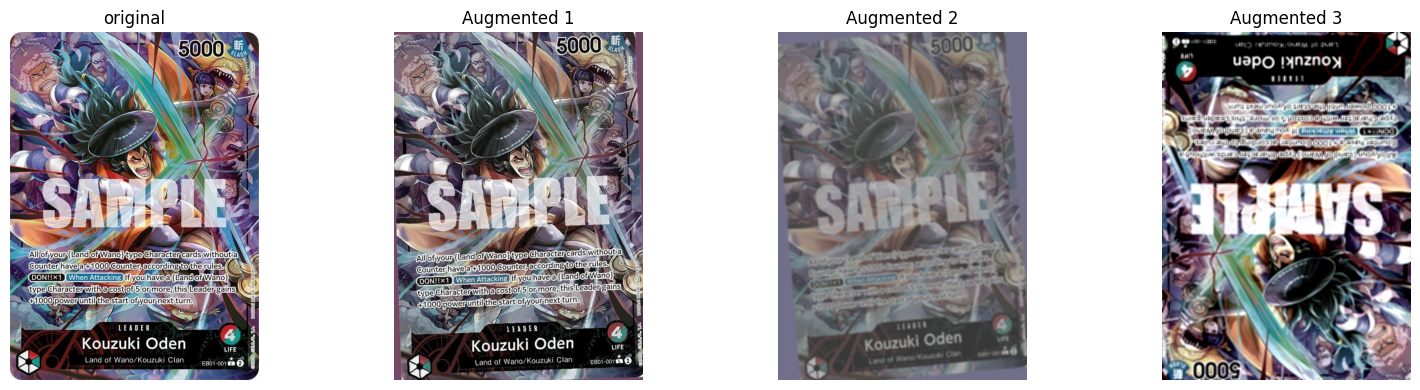

/content/dataset_copy/EN_EB01-002.jpg
2


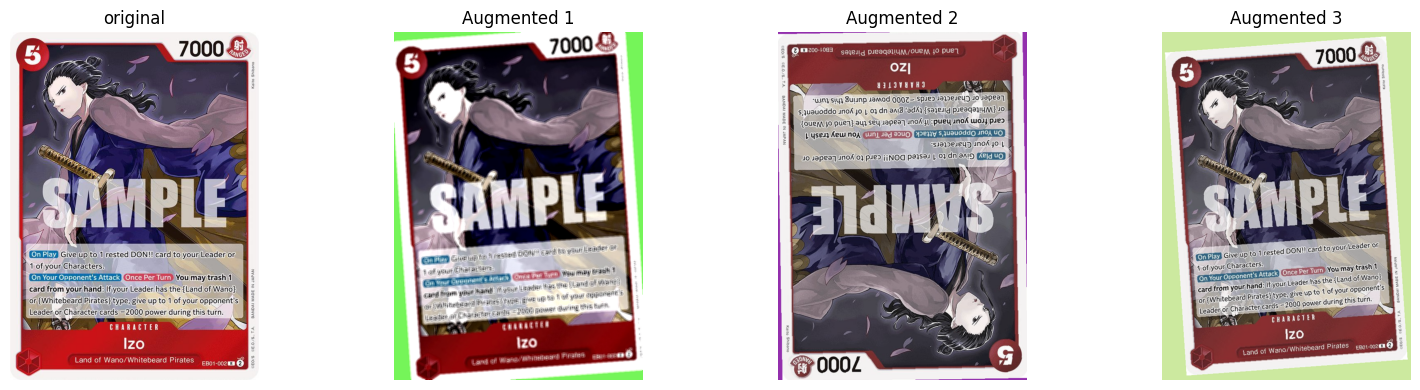

In [56]:
storage_path = "/content/augmented_data"

generate_augmented_images(file_paths, storage_path, sample_size=3, num_duplicates = 3)

Replace with keras dataloader

In [67]:
# # used to create raw image copies for training and augmentation
# def duplicate_images(file_path, label, num_duplicates=5):
#   return tf.data.Dataset.from_tensors((file_path, label)).repeat(num_duplicates)

# def preprocess_and_augment_image(image_path, label, image_size=(179,128)):
#   # load image
#   image = tf.io.read_file(image_path)
#   image = tf.image.decode_jpeg(image, channels=3)

#   # resize
#   image = tf.image.resize(image, image_size)

#   #augment
#   image = augment_image(image)

#   #normalize
#   image = image / 255.0

#   return image, label

# def create_dataset(dataset_path, sample_size=None, image_size=(179,128), batch_size=32):
#   # get file paths/labels
#   file_paths = get_file_paths(dataset_path, sample_size)
#   labels = extract_labels([os.path.basename(f) for f in file_paths])

#   #convert labels to integers
#   int_labels, unique_labels = convert_labels_to_int(labels)

#   # create a tf dataset
#   dataset = tf.data.Dataset.from_tensor_slices((file_paths, int_labels))

#   # duplicate each image and label
#   dataset = dataset.flat_map(lambda x, y: duplicate_images(x, y))

#   # apply preprocessing and augmentation to each image
#   dataset = dataset.map(lambda x, y: preprocess_and_augment_image(x, y, image_size),
#                         num_parallel_calls=tf.data.AUTOTUNE)

#   # shuffle and batch
#   dataset = dataset.shuffle(len(file_paths)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

#   return dataset

##Model Definition

In [66]:
def create_model(input_shape=(128, 179, 3), num_classes=None):
  model = models.Sequential([
      # First convolutional layer
      layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
      layers.MaxPooling2D((2, 2)),

      # Second convolutional layer
      layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape),
      layers.MaxPooling2D((2, 2)),

      # Third convolutional layer
      layers.Conv2D(128, (3, 3), activation='relu', input_shape=input_shape),
      layers.MaxPooling2D((2, 2)),

      # Flatten the output to feed into fully connected layers
      layers.Flatten(),

      # Fully connected (dense) layer
      layers.Dense(128, activation='relu'),

      # Output layer
      layers.Dense(num_classes, activation='softmax'),
  ])
  model.summary()

  return model

def compile_model(model, learning_rate=0.001):
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy']
  )

# Train the model
def train_model(model, dataset, epochs=10, batch_size=32):
    model.fit(dataset, epochs=epochs, batch_size=batch_size)

In [ ]:
model_test = create_model(input_shape=(179,128,3),num_classes=128)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 177, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 88, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 86, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 43, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 41, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 20, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 35840)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       4,587,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │          16,512 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,697,408 (17.92 MB)

 Trainable params: 4,697,408 (17.92 MB)

 Non-trainable params: 0 (0.00 B)

##Model Training

*everything below here needs edits

In [ ]:
dataset_path = "/content/drive/MyDrive/dataset/optcg_cards"
sample_size=128

dataset = create_dataset(dataset_path, sample_size, image_size=(179,128), batch_size=32)

model = create_model(input_shape=(179,128,3), num_classes=sample_size)

compile_model(model)

train_model(model, dataset, epochs=10)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 132ms/step - accuracy: 0.0251 - loss: 4.8683
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 137ms/step - accuracy: 0.0897 - loss: 4.6166
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 188ms/step - accuracy: 0.2753 - loss: 3.8138
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 0.4879 - loss: 2.1377
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 175ms/step - accuracy: 0.6319 - loss: 1.2845
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 194ms/step - accuracy: 0.6512 - loss: 1.1505
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.6770 - loss: 1.1349
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.7178 - loss: 0.8123
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.7450 - loss: 0.6807
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 176ms/step - accuracy: 0.7499 - loss: 0.6116


##Model Evaluation and Prediction

In [ ]:
test_dataset = create_dataset(dataset_path, sample_size)

loss, accuracy = model.evaluate(test_dataset)
print(f"Loss: {loss}, Accuracy: {accuracy}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 178ms/step - accuracy: 0.7664 - loss: 0.5874
Loss: 0.5138767957687378, Accuracy: 0.7875000238418579


In [ ]:
test_image = load_image("/content/drive/MyDrive/dataset/optcg_cards/EN_OP06-089_pPR.jpg")
test_image = tf.expand_dims(test_image, axis=0)  # Add batch dimension

predictions = model.predict(test_image)
predicted_class = unique_labels[tf.argmax(predictions[0]).numpy()]
print(f"Predicted Class: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
Predicted Class: EN_OP06-089_pPR
